# Network Training
Here we will train a our network on single noisy images.

In [1]:
%pip install -q matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from unet.model import UNet
from deconoising import utils
from deconoising import training
from tifffile import imread

# See if we can use a GPU
device = utils.getDevice()
import torch
from tifffile import imread, imsave
from scipy.ndimage import gaussian_filter

Note: you may need to restart the kernel to use updated packages.


/mnt/eternus/anaconda3_shared/envs/efficientbioai/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA available? True


## Download data
Download the data from https://cloud.mpi-cbg.de/index.php/s/BE8raMtHQlgLDF3/download. Here we show the pipeline for Convallaria dataset. Save the dataset in an appropriate path. For us, the path is the data folder which exists at ./. For Convallaria, the data to be denoised is named 20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif.

In [2]:
# Download data
import os
import urllib
import zipfile

if not os.path.isdir("./data"):
    os.mkdir("./data")

zipPath = "./data/Convallaria_diaphragm.zip"
if not os.path.exists(zipPath):
    data = urllib.request.urlretrieve(
        "https://cloud.mpi-cbg.de/index.php/s/BE8raMtHQlgLDF3/download", zipPath
    )
    with zipfile.ZipFile(zipPath, "r") as zip_ref:
        zip_ref.extractall("./data")

In [2]:
path = "./data/Convallaria_diaphragm/"
fileName = "20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif"
dataName = "convallaria"  # This will be used to name the network model

In [3]:
data_image = imread(path + fileName)
nameModel = dataName + "_network_example"  # specify the name of your network

Subtract the mean value of the background. It can be measured in Fiji, for example.
This is important for the positivity constraint, which requires the background to be at 0.

In [4]:
meanValue = 520.0
data = np.array(data_image).astype(np.float32)
data = data - meanValue

## Create PSF 
Here we can specify the size of PSF matrix in pixels (default is 81 * 81) and its size (standard deviation of Gaussian convolution  (default is 1.0)

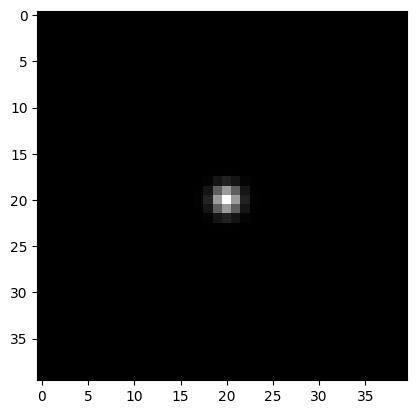

In [5]:
def artificial_psf(size_of_psf=81, std_gauss=1.0):
    filt = np.zeros((size_of_psf, size_of_psf))
    p = (size_of_psf - 1) // 2
    filt[p, p] = 1
    filt = torch.tensor(
        gaussian_filter(filt, std_gauss)
        .reshape(1, 1, size_of_psf, size_of_psf)
        .astype(np.float32)
    )
    filt = filt / torch.sum(filt)
    return filt


psf_tensor = artificial_psf(std_gauss=1.0)
plt.imshow(psf_tensor[0, 0, 20:60, 20:60], cmap="gray", interpolation="none")

## Show some training data

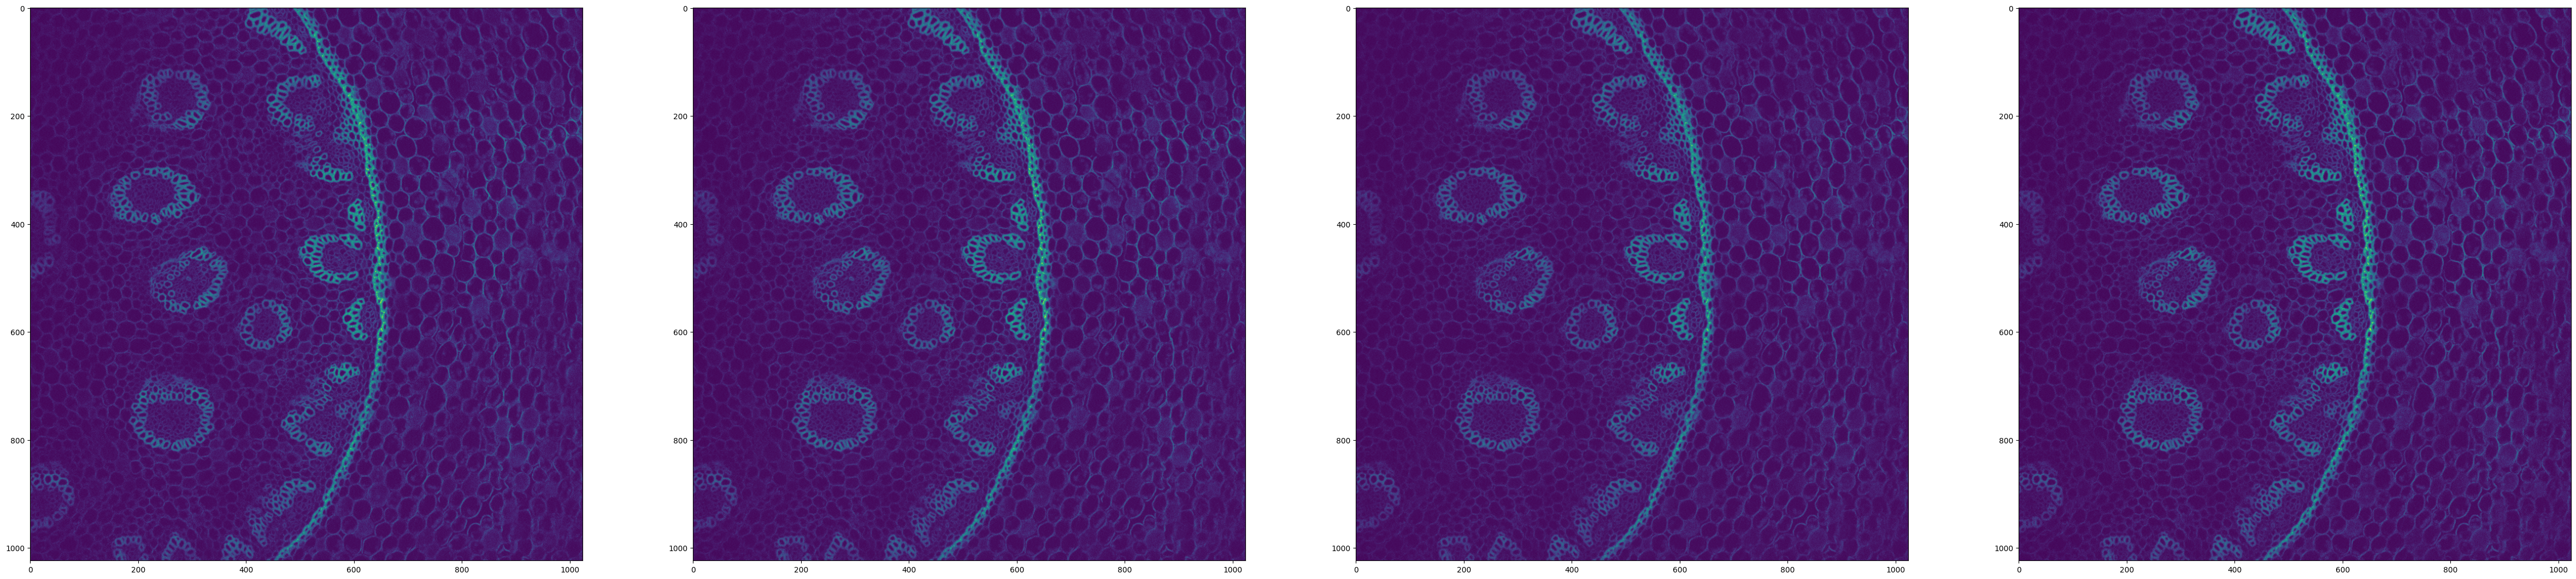

In [6]:
plt.figure(figsize=(60, 20))
plt.subplot(141)
plt.imshow(data[0])
plt.subplot(142)
plt.imshow(data[1])
plt.subplot(143)
plt.imshow(data[2])
plt.subplot(144)
plt.imshow(data[3])
plt.show()

## Create the Network and Train it
This can take a while. Before the run, you can adjust parameters, such as Number of Epochs, Steps per Epoch, Virtual Batch Size, Batch Size, Learning Rate, and our new parameter - Positivity Constraint, which can be turned of by setting it to 0. 
Note that you can improve the results at the cost of training time by increasing 'batchSize' or 'stepsPerEpoch'.

In [7]:
# The network requires only a single output unit per pixel
net = UNet(1, depth=3)
net.psf = psf_tensor.to(device)
# Split training and validation data.
my_train_data = data[:-5].copy()
my_val_data = data[-5:].copy()

# Start training.
trainHist, valHist = training.trainNetwork(
    net=net,
    trainData=my_train_data,
    valData=my_val_data,
    postfix=nameModel,
    directory=path,
    device=device,
    numOfEpochs=200,
    stepsPerEpoch=10,
    virtualBatchSize=20,
    batchSize=1,
    learningRate=1e-3,
    psf=psf_tensor.to(device),
    positivity_constraint=1,
)

/mnt/eternus/users/Yu/sandbox/EfficientBioAI/tutorial/DecoNoising/unet/model.py:215: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight)
/mnt/eternus/users/Yu/sandbox/EfficientBioAI/tutorial/DecoNoising/unet/model.py:216: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)


Epoch 0 finished      
avg. loss: 0.25045222602784634+-(2SEM)0.07073383089063949      
Epoch 1 finished      
avg. loss: 0.12531933113932608+-(2SEM)0.022104954175578635      
Epoch 2 finished      
avg. loss: 0.12548077385872602+-(2SEM)0.03867603097099295      
Epoch 3 finished      
avg. loss: 0.14387533143162728+-(2SEM)0.0507041385357441      
Epoch 4 finished      
avg. loss: 0.16764372531324626+-(2SEM)0.05466844826865563      
Epoch 5 finished      
avg. loss: 0.17697756476700305+-(2SEM)0.04626858678486183      
Epoch 6 finished      
avg. loss: 0.16526039503514767+-(2SEM)0.048222737651451165      
Epoch 7 finished      
avg. loss: 0.13287154752761127+-(2SEM)0.030082161954699385      
Epoch 8 finished      
avg. loss: 0.15525564160197974+-(2SEM)0.036400107459752445      
Epoch 9 finished      
avg. loss: 0.1349709413945675+-(2SEM)0.04083533513065414      
Epoch 10 finished      
avg. loss: 0.09331490211188793+-(2SEM)0.02484814601496364      
Epoch 11 finished      
avg. loss: 0.126